# Chapter 16: Advanced Technical Analysis and Market Prediction with Machine Learning

### Introduction:

In this chapter, we explore the intersection of technical analysis and machine learning to predict stock market movements and evaluate trading strategies. Using the Tiingo API, we retrieve historical stock data for Tesla (TSLA) and preprocess it to calculate daily log returns and create lag features for predictive modeling. 

Daily log returns (denoted as 'r' in the code) are the natural logarithm of the ratio of a stock's price from one day to the next, used to measure the percentage change in price on a daily basis, while lag features are past observations of a time series that are used as predictors to forecast future values. The direction of returns (denoted as 'd' in the code) is a binary variable indicating whether the next day's return is positive (1) or negative (-1).

The chapter covers the implementation of several technical indicators, including:

**Moving Averages (MA):** 
We calculate the 10-day and 50-day moving averages to smooth out price data and identify trends.

**Relative Strength Index (RSI):** 
This momentum oscillator measures the speed and change of price movements, helping to identify overbought or oversold conditions. An RSI above 70 typically indicates that an asset may be overbought and due for a price pullback, while an RSI below 30 suggests it may be oversold and due for a price rebound.

**Bollinger Bands**: 
These consist of a middle band (20-day moving average) and two outer bands (standard deviations above and below the moving average), used to identify volatility and potential price reversals. If the price is near the upper band, it may be overbought; if it's near the lower band, it may be oversold; and if the bands are widening, it signals increased volatility, while narrowing bands suggest decreased volatility.

**MACD (Moving Average Convergence Divergence):** 
A trend-following momentum indicator showing the relationship between two moving averages (12-day and 26-day), along with a 9-day signal line. A buy signal occurs when the MACD line crosses above the signal line, and a sell signal occurs when it crosses below.

**Stochastic Oscillator:** 
This momentum indicator compares the closing price to a range of prices over a 14-day period, helping to identify potential reversals.

These technical indicators are integrated into our dataset as additional features. We then employ a Random Forest Classifier, a powerful machine learning algorithm, to predict the market direction based on these features. The model is trained and tested using a split dataset, and its performance is evaluated using accuracy scores and classification reports. To validate the effectiveness of our predictive model, we conduct vectorized backtesting. This involves calculating strategy returns based on the model's predictions and comparing them to the actual market returns. We plot cumulative returns over time to visually assess the performance of our trading strategy.

Through this comprehensive analysis, the chapter shows how technical analysis indicators can be combined with machine learning techniques to predict market movements and evaluate the profitability of trading strategies.


## 16.1. Import several Python libraries that are commonly used for data analysis, machine learning, and visualization.

In [1]:
import os

# NumPy library, which is used for numerical operations and array manipulation.
import numpy as np

# Pandas library, which is used for data manipulation and analysis, especially tabular data.
import pandas as pd

# Matplotlib library for creating visualizations.
import matplotlib.pyplot as plt

# Seaborn library, which builds on Matplotlib to provide higher-level abstractions for creating attractive statistical graphics.
import seaborn as sns

from tiingo import TiingoClient

# Import the RandomForestClassifier from the scikit-learn library, which is used for classification tasks.
from sklearn.ensemble import RandomForestClassifier

# Import the accuracy_score and classification_report functions from scikit-learn for evaluating classification models.
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler                            # Normalize the features using MinMaxScaler later
from sklearn.model_selection import train_test_split                      # For train/test split

In [2]:
# Set up Tiingo API key
os.environ['TIINGO_API_KEY'] = 'YOUR KEY'
client = TiingoClient()

# Set plot style
plt.style.use('seaborn-darkgrid')

# Fetching TSLA stock data
symbol = "TSLA"
start_date = '2018-01-01'
end_date = '2024-06-30'

historical_prices = client.get_ticker_price(symbol, fmt='json', startDate=start_date, endDate=end_date, frequency='daily')

historical_prices[:2]

C:\Users\david\AppData\Local\Temp\ipykernel_8604\4016359099.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


[{'date': '2018-01-02T00:00:00.000Z',
  'close': 320.53,
  'high': 322.11,
  'low': 311.0,
  'open': 312.0,
  'volume': 4326988,
  'adjClose': 21.3686666667,
  'adjHigh': 21.474,
  'adjLow': 20.7333333333,
  'adjOpen': 20.8,
  'adjVolume': 64904820,
  'divCash': 0.0,
  'splitFactor': 1.0},
 {'date': '2018-01-03T00:00:00.000Z',
  'close': 317.25,
  'high': 325.25,
  'low': 315.55,
  'open': 321.0,
  'volume': 4185665,
  'adjClose': 21.15,
  'adjHigh': 21.6833333333,
  'adjLow': 21.0366666667,
  'adjOpen': 21.4,
  'adjVolume': 62784975,
  'divCash': 0.0,
  'splitFactor': 1.0}]

In [3]:
# Processing data
dates = [entry['date'] for entry in historical_prices]
prices = [entry['adjClose'] for entry in historical_prices]

# Creating a DataFrame
data = pd.DataFrame({'Date': pd.to_datetime(dates), symbol: prices})
data.set_index('Date', inplace=True)
print("DataFrame:\n", data.head())

# Calculate log returns (denoted as 'r')
data['r'] = np.log(data[symbol] / data[symbol].shift(1))

# Drop rows where returns are zero
data = data[data['r'] != 0.0]

data

# Create direction of returns (denoted as 'd', target for the next day for machine learning prediction)
data['d'] = np.sign(data['r'].shift(-1))

data

# Create lag features from returns
lags = 7
for lag in range(1, lags + 1):
    data[f'lag_{lag}'] = data['r'].shift(lag)

data

DataFrame:
                                 TSLA
Date                                
2018-01-02 00:00:00+00:00  21.368667
2018-01-03 00:00:00+00:00  21.150000
2018-01-04 00:00:00+00:00  20.974667
2018-01-05 00:00:00+00:00  21.105333
2018-01-08 00:00:00+00:00  22.427333


,TSLA,r,d,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,,,
2018-01-02 00:00:00+00:00,21.368667,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00+00:00,21.150000,-0.010286,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04 00:00:00+00:00,20.974667,-0.008325,1.0,-0.010286,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05 00:00:00+00:00,21.105333,0.006210,1.0,-0.008325,-0.010286,NaN,NaN,NaN,NaN,NaN
2018-01-08 00:00:00+00:00,22.427333,0.060755,-1.0,0.006210,-0.008325,-0.010286,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-06-24 00:00:00+00:00,182.580000,-0.002352,1.0,0.007900,-0.017958,-0.013860,0.051619,-0.024746,0.028799,0.038114
2024-06-25 00:00:00+00:00,187.350000,0.025790,1.0,-0.002352,0.007900,-0.017958,-0.013860,0.051619,-0.024746,0.028799
2024-06-26 00:00:00+00:00,196.370000,0.047022,1.0,0.025790,-0.002352,0.007900,-0.017958,-0.013860,0.051619,-0.024746


## 16.2. Calculating Technical Indicators

In [4]:
# Calculate moving averages
data['MA_10'] = data[symbol].rolling(window=10).mean()
data['MA_50'] = data[symbol].rolling(window=50).mean()

# Calculate RSI
delta = data[symbol].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Calculate Bollinger Bands
data['MA_20'] = data[symbol].rolling(window=20).mean()
data['BB_upper'] = data['MA_20'] + (data[symbol].rolling(window=20).std() * 2)
data['BB_lower'] = data['MA_20'] - (data[symbol].rolling(window=20).std() * 2)

# Calculate MACD
data['EMA_12'] = data[symbol].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data[symbol].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Calculate Stochastic Oscillator
data['L14'] = data[symbol].rolling(window=14).min()
data['H14'] = data[symbol].rolling(window=14).max()
data['%K'] = (data[symbol] - data['L14']) * 100 / (data['H14'] - data['L14'])
data['%D'] = data['%K'].rolling(window=3).mean()

# Print the data
print("First 5 columns:")
print(data.iloc[:, :5])

print("\nLast 5 columns:")
print(data.iloc[:, -5:])

# Update feature list
features = [f'lag_{lag}' for lag in range(1, lags + 1)] + ['MA_10', 'MA_50', 'RSI', 'BB_upper', 'BB_lower', 'MACD', 'Signal_Line', '%K', '%D']

# Drop NaN values
data.dropna(inplace=True)

data.head()

First 5 columns:
                                 TSLA         r    d     lag_1     lag_2
Date                                                                    
2018-01-02 00:00:00+00:00   21.368667       NaN -1.0       NaN       NaN
2018-01-03 00:00:00+00:00   21.150000 -0.010286 -1.0       NaN       NaN
2018-01-04 00:00:00+00:00   20.974667 -0.008325  1.0 -0.010286       NaN
2018-01-05 00:00:00+00:00   21.105333  0.006210  1.0 -0.008325 -0.010286
2018-01-08 00:00:00+00:00   22.427333  0.060755 -1.0  0.006210 -0.008325
...                               ...       ...  ...       ...       ...
2024-06-24 00:00:00+00:00  182.580000 -0.002352  1.0  0.007900 -0.017958
2024-06-25 00:00:00+00:00  187.350000  0.025790  1.0 -0.002352  0.007900
2024-06-26 00:00:00+00:00  196.370000  0.047022  1.0  0.025790 -0.002352
2024-06-27 00:00:00+00:00  197.420000  0.005333  1.0  0.047022  0.025790
2024-06-28 00:00:00+00:00  197.880000  0.002327  NaN  0.005333  0.047022

[1632 rows x 5 columns]

Last 5 c

,TSLA,r,d,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,BB_upper,BB_lower,EMA_12,EMA_26,MACD,Signal_Line,L14,H14,%K,%D
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-14 00:00:00+00:00,21.775333,-0.045515,-1.0,-0.010679,0.054542,-0.005882,-0.009677,0.012415,-0.015570,-0.005296,...,23.734901,21.196965,22.337198,22.371944,-0.034746,0.004644,21.775333,23.828000,0.0,36.374656
2018-03-15 00:00:00+00:00,21.706667,-0.003158,-1.0,-0.045515,-0.010679,0.054542,-0.005882,-0.009677,0.012415,-0.015570,...,23.713640,21.240160,22.240194,22.322664,-0.082471,-0.012779,21.706667,23.828000,0.0,16.165289
2018-03-16 00:00:00+00:00,21.423333,-0.013139,-1.0,-0.003158,-0.045515,-0.010679,0.054542,-0.005882,-0.009677,0.012415,...,23.756145,21.112855,22.114523,22.256047,-0.141524,-0.038528,21.423333,23.399333,0.0,0.000000
2018-03-19 00:00:00+00:00,20.904000,-0.024540,-1.0,-0.013139,-0.003158,-0.045515,-0.010679,0.054542,-0.005882,-0.009677,...,23.850158,20.872642,21.928288,22.155896,-0.227607,-0.076344,20.904000,23.034000,0.0,0.000000
2018-03-20 00:00:00+00:00,20.703333,-0.009646,1.0,-0.024540,-0.013139,-0.003158,-0.045515,-0.010679,0.054542,-0.005882,...,23.944198,20.617135,21.739834,22.048298,-0.308465,-0.122768,20.703333,23.034000,0.0,0.000000


## 16.3.Normalize the specified features in the DataFrame data using the MinMaxScaler.

In [5]:
# Drop NaNs
data.dropna(inplace=True)

## 16.3. Normalize Features & Train-Test Split

# Define features
features = [f'lag_{lag}' for lag in range(1, lags + 1)] + ['MA_10', 'MA_50', 'RSI', 'BB_upper', 'BB_lower', 'MACD', 'Signal_Line', '%K', '%D']
target = 'd'

# Time-based train/test split
split_index = int(0.7 * len(data))
train_data = data.iloc[:split_index].copy()
test_data = data.iloc[split_index:].copy()

# Normalize using only training data
scaler = MinMaxScaler()
scaler.fit(train_data[features])

train_data[features] = scaler.transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])

# Separate X/y
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]


In [6]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)
test_data = test_data.assign(p_rf=y_pred)

# Accuracy and report
rf_accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Prediction Accuracy: {rf_accuracy:.2f}')
print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Prediction Accuracy: 0.52
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.53      0.38      0.44       237
         1.0       0.52      0.67      0.58       238

    accuracy                           0.52       475
   macro avg       0.52      0.52      0.51       475
weighted avg       0.52      0.52      0.51       475



## 16.4. Backtesting

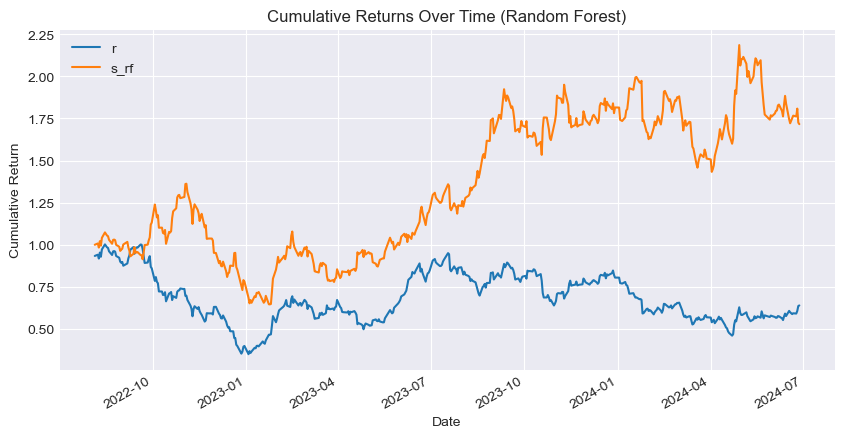

Gross Returns with Random Forest:
 r       0.639659
s_rf    1.716382
dtype: float64


In [7]:
# Strategy returns
test_data['s_rf'] = test_data['p_rf'].shift(1).fillna(0) * test_data['r']
test_data.dropna(inplace=True)

# Cumulative returns
cumulative_returns_rf = test_data[['r', 's_rf']].cumsum().apply(np.exp)

# Plot
cumulative_returns_rf.plot(title='Cumulative Returns Over Time (Random Forest)', figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

# Gross Returns
gross_returns_rf = test_data[['r', 's_rf']].sum().apply(np.exp)
print("Gross Returns with Random Forest:\n", gross_returns_rf)


## Additional Comments

The strategies and models discussed in this chapter are based on theoretical assumptions and are implemented using historical data analysis and machine learning techniques for educational purposes. While these models can provide valuable insights, it is crucial to understand the limitations and unrealistic assumptions inherent in these approaches when applying them to real-life trading scenarios. Specifically:

#### Perfect Execution at Close Prices: The models assume that trades can be executed exactly at the closing prices of the day. In reality, executing trades at the exact closing prices is challenging due to market dynamics, order flow, and execution delays.

#### No Transaction Costs: The models do not account for any transaction costs, such as broker fees, taxes, or slippage. In real life, every trade incurs costs, which can significantly impact net returns.

#### No Market Impact: The models assume that the trader's orders do not impact the market price. In practice, large orders, especially in less liquid markets, can move prices, making it difficult to execute trades at desired prices.

#### No Slippage: The models assume there is no slippage between the intended execution price and the actual execution price. Slippage is common, especially in volatile markets, where the actual trade price can differ from the expected price.

#### No Liquidity Constraints: The models assume unlimited liquidity, meaning the trader can buy or sell any amount of stock without issues. Liquidity constraints can make it difficult to execute large orders without significantly affecting the price.

#### Immediate Execution: The models assume trades are executed immediately upon making a decision. Delays in trade execution can occur due to various reasons, including order processing times and market conditions.

#### No Behavioral Factors: The models assume trading decisions are made purely based on predictions without any psychological or behavioral biases. Human traders are often influenced by emotions and biases, which can affect their decision-making process.

#### Stable Market Conditions: The models assume stable market conditions and do not account for extreme market events or anomalies. Markets can experience extreme volatility, crashes, and other anomalies that can disrupt trading strategies.

## 16.5 Summary

In this chapter, we explore the combination of technical analysis and machine learning for stock market prediction. Using Tesla's (TSLA) historical data, we implement various technical indicators and employ machine learning to forecast market direction.